# Lab 2
## Introducció
L’objectiu d’aquesta pràctica és simular la codificació que tindria un senyal d'àudio a l’enviar-se, comprimir-se/descomprimir-se i altres processos. Basada en la DFT (Discrete Fourier Transform) per bandes. 

## Process
    Ex 1: Transformació del Bloc
    Ex 2: Disseny de les bandes de freqüència
    Ex 3: Assignació i quantificació de bits fixes
    Ex 4: Enfinestrat i Solapament
    Ex 5: Variabilitat dels bits


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
from block_transform import transform, transform_overlap
import sounddevice as sd
import math

#### Inicialitzacció

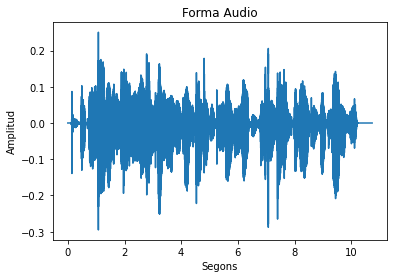

In [2]:
# Read the auido file
audio, fsaudio = sf.read('wavs/es01_m44.wav')
# Create the time array corresponding with the aduio
time = np.linspace(0, (len(audio)-1)/fsaudio, num=len(audio-1))

winL = 1024
nBands = 5
n_bits = 8

# Plot of the audio
plt.plot(time, audio)
plt.title('Forma Audio')
plt.xlabel('Segons')
plt.ylabel('Amplitud')
plt.show()

### - Ex 1 - Transformació del Bloc

La primera part consisteix a implementar les bases del programa on inicialment s’aplicarà la FFT i la IFFT per a recuperar la senyal original.

Llegirem la senyal inicial i la seva freqüència, guardant-les en el nostre cas amb les variables audio i fsaudio. Com l'àudio no és constant, es defineix la mida de les finestres en les quals l'àudio es dividirà per a fer la FFT (és important tenir en compte que la mida de les finestres ha de ser un nombre en potència de dos perquè la FFT ho requereix). En el cas d’aquest programa una bona mesura és de 1024 mostres.

En la següent imatge es pot apreciar de quina manera recuperem la senyal original o àudio, on h equival a un frame de 1024 mostres on finalment se sumen entre ells i es recupera la senyal original.

<img src="Images/Transform block.png">

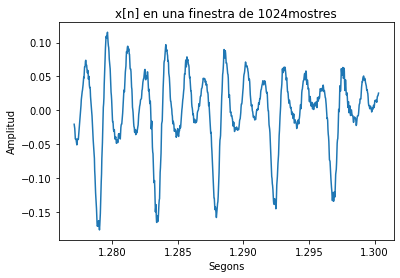

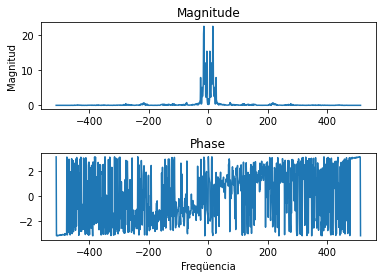

In [3]:
# Plot a part of the signal in time, magnitud and phase
doQuantizationByBands = 0
waveOut = transform(audio, nBands, n_bits, winL, doQuantizationByBands, time)

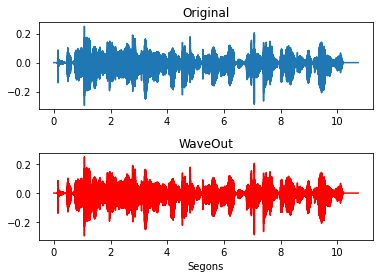

In [4]:
# Compare plot of the original and final signal
fig1, (mX, nX) = plt.subplots(2, 1)
fig1.subplots_adjust(hspace=0.5, wspace=0)

mX.plot(time, audio)
mX.set_title('Original')
nX.plot(time, waveOut, 'r')
nX.set_title('WaveOut')
plt.xlabel('Segons')
plt.show()

Recuperació del audio:

In [5]:
wavfile.write("final_audios/waveOut.wav", fsaudio, waveOut)

### - Ex 2 i 3 - DFT amb quantització per bandes amb una finestra rectangular
Ara comença la quantització i codificació del programa, ja que fins al moment podem dir que l’àudio només es transforma fins al domini freqüencial. 
Dividirem la senyal del frame en diferents bandes per a poder-les codificar sense gran problema i per a cada banda, hi haurà una amplitud de codificació determinada, que va disminuint en funció que canvia de banda.

<img src="Images/QuantizationBnads.PNG">

In [6]:
# Quantization bands with no overlapping and rectangular window
doQuantizationByBands = 1
waveOut_quantized = transform(audio, nBands, n_bits, winL, doQuantizationByBands, time)

# Compute Bitrate
bitrate = n_bits*fsaudio
print('BITRATE exercici 3:', bitrate/1000, ' Kbits/s')

BITRATE exercici 3: 352.8  Kbits/s


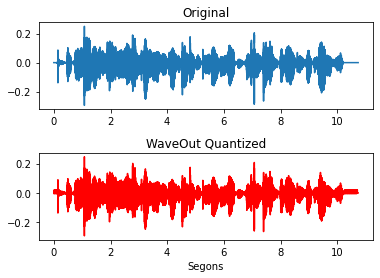

In [7]:
# Compare plot of the original and final signal
fig2, (mX, nX) = plt.subplots(2, 1)
fig2.subplots_adjust(hspace=0.5, wspace=0)

mX.plot(time, audio)
mX.set_title('Original')
nX.plot(time, waveOut_quantized, 'r')
nX.set_title('WaveOut Quantized')
plt.xlabel('Segons')
plt.show()

Reproducció del audio

In [8]:
sd.play(waveOut_quantized, fsaudio)
status = sd.wait()

Recuperació del audio:

In [9]:
wavfile.write("final_audios/waveOut_quantized.wav", fsaudio, waveOut_quantized)

### - Ex 4 - Enfinestrat i Solapament
Per a evitar els artefactes que se senten fins ara, usarem un overlap factor a l’hora de passar la finestra, la qual no serà rectangular. L’overlap factor indica quant de tros del senyal enfinestrat en el frame previ estarà inclòs en l’enfinestrament del frame actual. Aquestes repeticions en la informació faran que el senyal es reconstrueixi de forma molt més fidel. 

In [10]:
# Quantization bands with oberlapping and a hamming window
window = np.hanning(winL)
overlap = 0.75
waveOut_Overlap, _ = transform_overlap(audio, nBands, n_bits, winL, overlap, window, doQuantizationByBands, False)

# Compute bitrate
num_windows = math.ceil(len(audio)/(winL*(1-overlap))) - int(1/(1-overlap))
nbits_total = n_bits * winL * num_windows
bitrate2 = (nbits_total * fsaudio) / len(audio)
print('BITRATE exercici 4 (Overlap-Add):', '%.2f' % (bitrate2/1000), 'Kbits/s')

BITRATE exercici 4 (Overlap-Add): 1408.83 Kbits/s


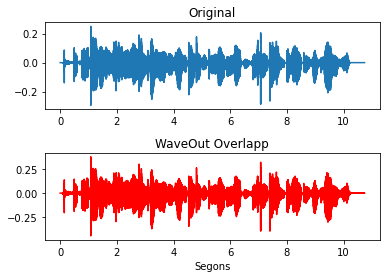

In [11]:
# Compare plot of the original and final signal
fig3, (mX, nX) = plt.subplots(2, 1)
fig3.subplots_adjust(hspace=0.5, wspace=0)

mX.plot(time, audio)
mX.set_title('Original')
nX.plot(time, waveOut_Overlap, 'r')
nX.set_title('WaveOut Overlapp')
plt.xlabel('Segons')
plt.show()

Reproducció del audio

In [12]:
sd.play(waveOut_Overlap, fsaudio)
status = sd.wait()

Recuperació del audio:

In [13]:
wavfile.write("final_audios/waveOut_Overlap.wav", fsaudio, waveOut_Overlap)

### - Ex 5 - Variabilitat del bits
Per estalviar bits, memòria, l’exercici 5 proposa no codificar les bandes que tinguessin menys informació o informació nulla, posant un llindar anomenat **energyThreshold** que a partir de l’amplada de les bandes de codificació descartava si valia la pena o no codificar-lo amb la següent línia de codi:
        
        # Coder
        if max(np.abs(freqFrame)) > (max_amplitude/energyThreshold):


In [14]:
# Variable Quantization Bands
doQuantizationByBands = 5
window = np.hanning(winL)
overlap = 0.75
energyThreshold = 5

waveOut_variable, nbits_total = transform_overlap(audio, nBands, n_bits, winL, overlap, window, doQuantizationByBands, energyThreshold)

# Compute Bitrate
bitrate3 = (nbits_total * fsaudio) / len(audio)
print('BITRATE exercici 5 (Variable):', '%.2f' % (bitrate3/1000), 'Kbits/s')


BITRATE exercici 5 (Variable): 548.46 Kbits/s


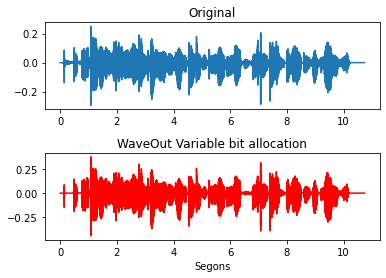

In [15]:
# Compare plot of the original and final signal
fig4, (mX, nX) = plt.subplots(2, 1)
fig4.subplots_adjust(hspace=0.5, wspace=0)

mX.plot(time, audio)
mX.set_title('Original')
nX.plot(time, waveOut_variable, 'r')
nX.set_title('WaveOut Variable bit allocation')
plt.xlabel('Segons')
plt.show()

Reproducció del audio

In [16]:
sd.play(waveOut_variable, fsaudio)
status = sd.wait()

Recuperació del audio:

In [17]:
wavfile.write("final_audios/waveOut_variable.wav", fsaudio, waveOut_variable)